In [2]:
import pandas as pd

In [3]:
movies = pd.read_csv("results_with_crew.csv")
reviews = pd.read_csv("Movies_Reviews_modified_version1.csv")

In [5]:
print(reviews.columns)

Index(['Unnamed: 0', 'Ratings', 'Reviews', 'movie_name', 'Resenhas', 'genres',
       'Description', 'emotion'],
      dtype='object')


In [6]:
reviews.columns = reviews.columns.str.strip()
reviews.columns = reviews.columns.str.lower()
reviews.columns = reviews.columns.str.replace(" ", "_")

print(reviews.columns)

Index(['unnamed:_0', 'ratings', 'reviews', 'movie_name', 'resenhas', 'genres',
       'description', 'emotion'],
      dtype='object')


In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

reviews['sentiment_score'] = reviews['reviews'].astype(str).apply(
    lambda x: sia.polarity_scores(x)['compound']
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
print(reviews.head())

   unnamed:_0  ratings                                            reviews  \
0           0      3.0  It had some laughs, but overall the motivation...   
1           1      4.0  WAITING TO EXHALE Waiting, and waiting, and wa...   
2           2      4.0  Angela Basset was good as expected, but Whitne...   
3           3      5.0  The movie is okay, mediocre might even be the ...   
4           4      5.0  I got an opportunity to see Waiting To Exhale ...   

          movie_name                                           resenhas  \
0  Waiting to Exhale  Riu algumas risadas, mas no geral a motivação ...   
1  Waiting to Exhale  ESPERANDO PARA EXALAR Esperando, e esperando, ...   
2  Waiting to Exhale  Angela Basset foi boa como o esperado, mas Whi...   
3  Waiting to Exhale  O filme é bom, medíocre pode até ser a palavra...   
4  Waiting to Exhale  Tive a oportunidade de ver Waiting To Exhale p...   

                           genres  \
0  ['Comedy', 'Drama', 'Romance']   
1  ['Comedy'

In [9]:
movie_sentiment = reviews.groupby('movie_name').agg({
    'sentiment_score': 'mean',
    'ratings': 'mean'
}).reset_index()

In [10]:
merged = pd.merge(
    movies,
    movie_sentiment,
    left_on='primaryTitle',
    right_on='movie_name',
    how='inner'
)

In [11]:
merged['Success'] = merged['averageRating'].apply(lambda x: 1 if x >= 7 else 0)

In [12]:
merged['runtimeMinutes'] = pd.to_numeric(merged['runtimeMinutes'], errors='coerce')

In [13]:
merged['startYear'] = pd.to_numeric(merged['startYear'], errors='coerce')

In [15]:
print(merged.columns)

Index(['tconst', 'primaryTitle', 'startYear', 'rank', 'averageRating',
       'numVotes', 'runtimeMinutes', 'directors', 'writers', 'genres',
       'IMDbLink', 'Title_IMDb_Link', 'movie_name', 'sentiment_score',
       'ratings', 'Success', 'rating_norm'],
      dtype='object')


In [16]:
movie_sentiment = reviews.groupby('movie_name').agg({
    'sentiment_score': 'mean',
    'ratings': 'mean'
}).reset_index()

movie_sentiment.rename(columns={
    'sentiment_score': 'avg_sentiment',
    'ratings': 'avg_review_rating'
}, inplace=True)

In [17]:
merged = pd.merge(
    movies,
    movie_sentiment,
    left_on='primaryTitle',
    right_on='movie_name',
    how='inner'
)

In [18]:
merged['rating_norm'] = merged['averageRating'] / 10
merged['sentiment_norm'] = (merged['avg_sentiment'] + 1) / 2

In [19]:
merged['Review_Index'] = (
    0.5 * merged['rating_norm'] +
    0.3 * merged['sentiment_norm'] +
    0.2 * (merged['avg_review_rating'] / 10)
)

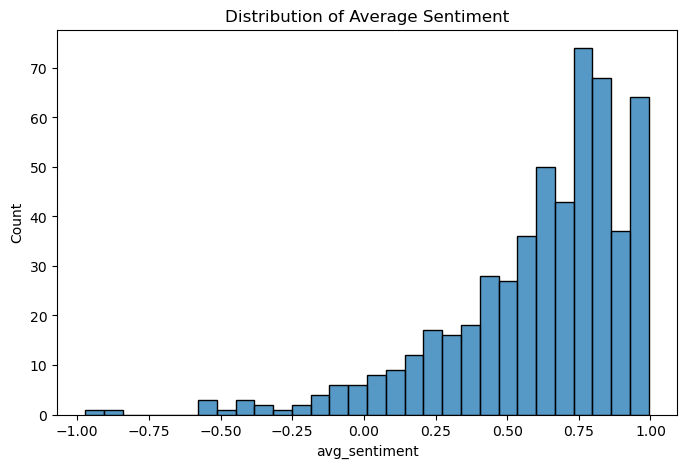

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.histplot(merged['avg_sentiment'], bins=30)
plt.title("Distribution of Average Sentiment")
plt.show()


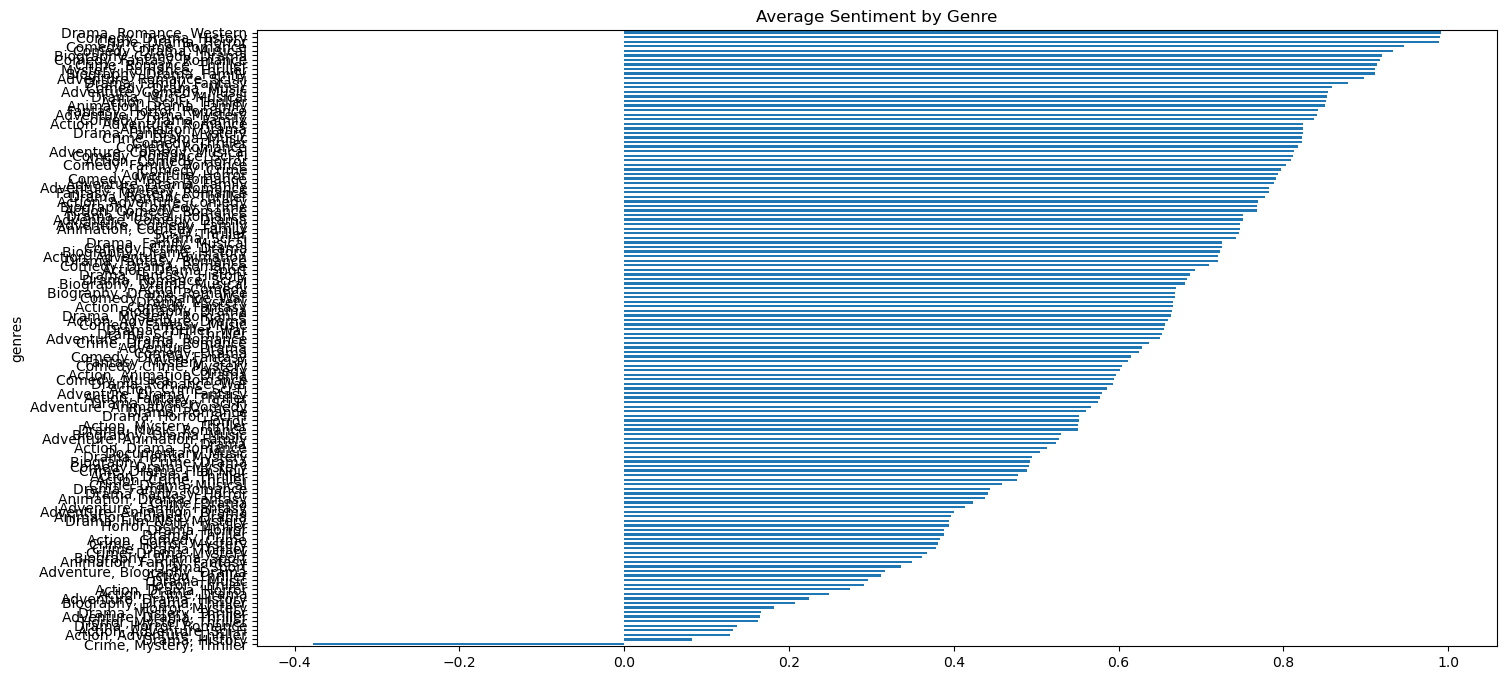

In [23]:
genre_sentiment = merged.groupby('genres')['avg_sentiment'].mean().sort_values()

plt.figure(figsize=(16,8))
genre_sentiment.plot(kind='barh')
plt.title("Average Sentiment by Genre")
plt.show()

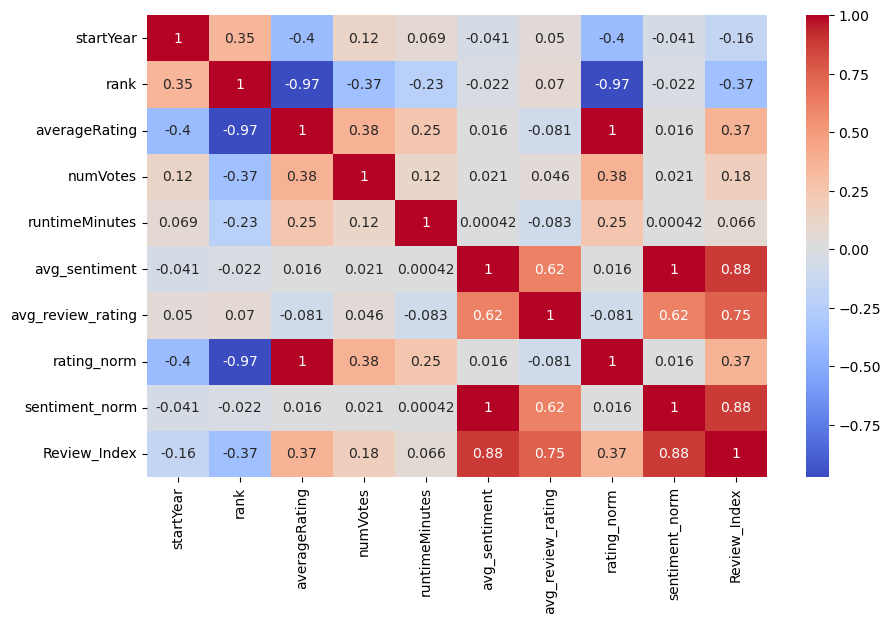

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

In [26]:
print(merged.columns)

Index(['tconst', 'primaryTitle', 'startYear', 'rank', 'averageRating',
       'numVotes', 'runtimeMinutes', 'directors', 'writers', 'genres',
       'IMDbLink', 'Title_IMDb_Link', 'movie_name', 'avg_sentiment',
       'avg_review_rating', 'rating_norm', 'sentiment_norm', 'Review_Index'],
      dtype='object')


In [27]:
merged['numVotes'] = pd.to_numeric(merged['numVotes'], errors='coerce')
merged['runtimeMinutes'] = pd.to_numeric(merged['runtimeMinutes'], errors='coerce')
merged['averageRating'] = pd.to_numeric(merged['averageRating'], errors='coerce')
merged['avg_sentiment'] = pd.to_numeric(merged['avg_sentiment'], errors='coerce')
merged['Review_Index'] = pd.to_numeric(merged['Review_Index'], errors='coerce')

In [28]:
merged = merged.dropna(subset=[
    'numVotes', 'runtimeMinutes',
    'avg_sentiment', 'Review_Index',
    'averageRating'
])

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

features = merged[['numVotes', 'runtimeMinutes',
                   'avg_sentiment', 'Review_Index']]

target = merged['averageRating']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

predictions = reg_model.predict(X_test)

print("R2 Score:", r2_score(y_test, predictions))
print("RMSE:", mean_squared_error(y_test, predictions, squared=False))

R2 Score: 0.6735139742691396
RMSE: 0.3682968526976592


In [30]:
import numpy as np

merged['log_votes'] = np.log1p(merged['numVotes'])

In [31]:
merged['Success'] = merged['averageRating'].apply(lambda x: 1 if x >= 7 else 0)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

features_class = merged[['log_votes', 'runtimeMinutes',
                         'avg_sentiment', 'Review_Index']]

target_class = merged['Success']

X_train, X_test, y_train, y_test = train_test_split(
    features_class, target_class,
    test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.61      0.67        33
           1       0.84      0.91      0.87        75

    accuracy                           0.81       108
   macro avg       0.79      0.76      0.77       108
weighted avg       0.81      0.81      0.81       108



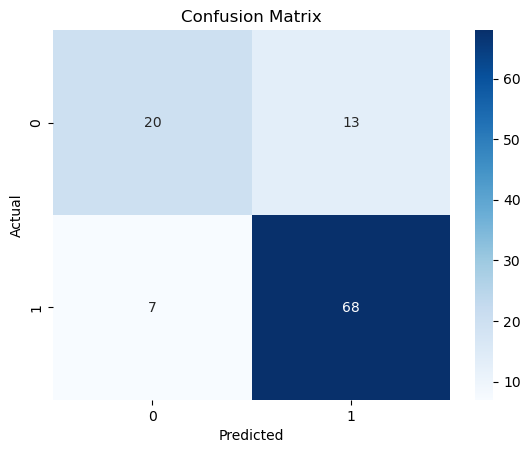

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

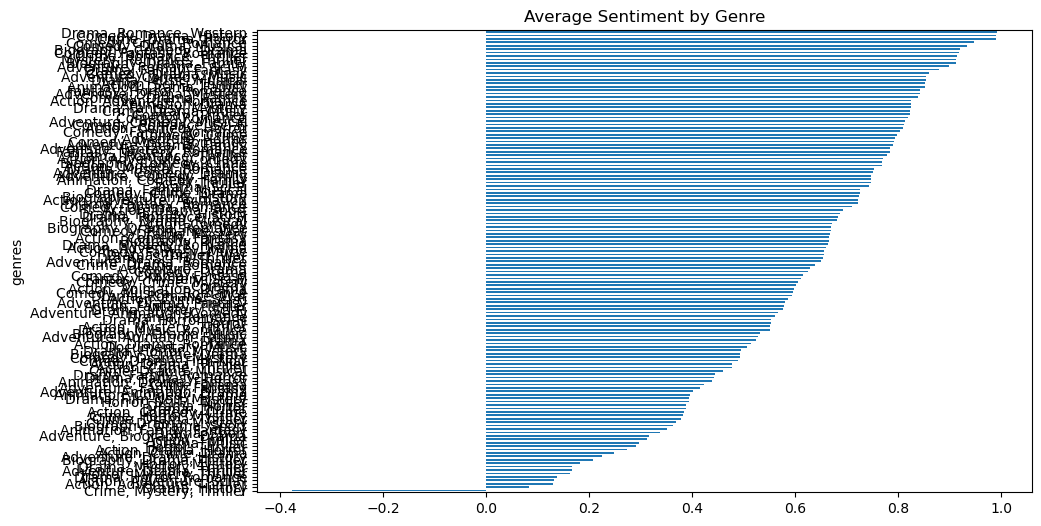

In [34]:
genre_sentiment = merged.groupby('genres')['avg_sentiment'].mean().sort_values()

plt.figure(figsize=(10,6))
genre_sentiment.plot(kind='barh')
plt.title("Average Sentiment by Genre")
plt.show()

In [35]:
merged.to_excel("final_movie_analysis.xlsx", index=False)
genre_sentiment.to_excel("genre_sentiment.xlsx")

In [36]:
merged['log_votes'] = np.log1p(merged['numVotes'])

In [37]:
merged = pd.get_dummies(merged, columns=['genres'], drop_first=True)

In [40]:
review_count = reviews.groupby('movie_name').size().reset_index(name='review_count')

merged = pd.merge(merged, review_count,
                  left_on='primaryTitle',
                  right_on='movie_name',
                  how='left')

C:\Users\harsh\AppData\Local\Temp\ipykernel_23968\2793476585.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'movie_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged = pd.merge(merged, review_count,
